# Baseline Model Development Notebook (Hashing Trick)

## Основные исправления:
1. ✅ Frequency Encoding УДАЛЁН (предотвращена data leakage через Store_Freq/Dept_Freq)
2. ✅ Hashing Trick для Store и Dept (40 признаков вместо 128)
3. ✅ OneHotEncoding для Type и IsHoliday (мало категорий)
4. ✅ Правильное разделение временных рядов без перекрытия дат

## 1: Импорт библиотек и настройка окружения

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime
import joblib, os, json

# Настройки визуализации
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

# ML библиотеки
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Модели
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

# Custom transformer для Frequency Encoding
from sklearn.base import BaseEstimator, TransformerMixin

print("Библиотеки загружены!")

Библиотеки загружены!


## 2: OneHotEncoding для всех категориальных признаков

✅ **ИСПРАВЛЕНИЕ**: Убран Frequency Encoding для предотвращения data leakage.
Все категориальные признаки кодируются через OneHotEncoding внутри Pipeline.

## 3: Загрузка обработанных данных из EDA

In [2]:
# Загрузка данных
df = pd.read_csv('data/raw/walmart_cleaned.csv', parse_dates=['Date'])

print(f"✓ Данные успешно загружены")
print(f"Размер датасета: {df.shape}")
print(f"Колонки: {df.columns.tolist()}")
print(f"\nПервые 3 строки:")
display(df.head(3))

✓ Данные успешно загружены
Размер датасета: (421570, 17)
Колонки: ['Unnamed: 0', 'Store', 'Date', 'IsHoliday', 'Dept', 'Weekly_Sales', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'Type', 'Size']

Первые 3 строки:


,Unnamed: 0,Store,Date,IsHoliday,Dept,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,0,1,2010-02-05,0,1.0,24924.50,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,3,151315
1,1,1,2010-02-05,0,26.0,11737.12,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,3,151315
2,2,1,2010-02-05,0,17.0,13223.76,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,3,151315


## 4: Проверка и создание результатов EDA

In [3]:
# Проверяем, есть ли файл с результатами EDA
eda_summary_path = 'reports/eda/eda_summary.json'
if os.path.exists(eda_summary_path):
    with open(eda_summary_path, 'r') as f:
        eda_summary = json.load(f)
    print("✓ Результаты EDA загружены из файла")
else:
    print("⚠ Файл с результатами EDA не найден. Создаем базовую структуру...")
    
    eda_summary = {
        'dataset_shape': df.shape,
        'missing_values': int(df.isnull().sum().sum()),
        'outlier_percentage': 8.43,
        'top_correlated_features': {
            'Size': 0.2438,
            'Type': 0.1822,
            'Dept': 0.1480
        },
        'key_insights': [
            'Размер магазина - наиболее коррелированный признак (0.24)',
            '8.43% данных - выбросы в целевой переменной',
            'Яркая сезонность с пиками в праздничный сезон'
        ]
    }
    
    os.makedirs('reports/eda', exist_ok=True)
    with open(eda_summary_path, 'w') as f:
        json.dump(eda_summary, f, indent=2, ensure_ascii=False)

print(f"\nКлючевые выводы EDA:")
for insight in eda_summary['key_insights']:
    print(f"  • {insight}")

✓ Результаты EDA загружены из файла

Ключевые выводы EDA:
  • Размер магазина - наиболее коррелированный признак (0.24)
  • 8.43% данных - выбросы в целевой переменной
  • Яркая сезонность с пиками в праздничный сезон
  • Выбросы не случайны, следуют временным паттернам
  • Отсутствие сильной мультиколлинеарности


## 5: Подготовка данных для Baseline моделей

In [4]:
# BASELINE: Подготовка данных
df_baseline = df.copy()

# 1. Удаляем технические столбцы
df_baseline = df_baseline.drop(['Unnamed: 0'], axis=1, errors='ignore')

# 2. Временные признаки
df_baseline['Year'] = df_baseline['Date'].dt.year
df_baseline['Month'] = df_baseline['Date'].dt.month
df_baseline['WeekOfYear'] = df_baseline['Date'].dt.isocalendar().week
df_baseline['Quarter'] = df_baseline['Date'].dt.quarter

# 3. Определение признаков и целевой
target = 'Weekly_Sales'
X = df_baseline.drop([target, 'Date'], axis=1)
y = df_baseline[target]

# 4. Разделение на категориальные и числовые
categorical_features = ['Store', 'Dept', 'Type', 'IsHoliday']
numerical_features = [col for col in X.columns if col not in categorical_features]

print(f" Размеры: X={X.shape}, y={y.shape}")
print(f" Целевая: {target} (мин={y.min():,.0f}, макс={y.max():,.0f}, сред={y.mean():,.0f})")
print(f" Категориальные ({len(categorical_features)}): {categorical_features}")
print(f" Числовые ({len(numerical_features)}): {numerical_features[:5]}...")

 Размеры: X=(421570, 18), y=(421570,)
 Целевая: Weekly_Sales (мин=-4,989, макс=693,099, сред=15,981)
 Категориальные (4): ['Store', 'Dept', 'Type', 'IsHoliday']
 Числовые (14): ['Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3']...


## 6: Сохранение обработанных данных

In [5]:
# Сохраняем обработанные данные
os.makedirs('data/processed', exist_ok=True)
processed_data_path = 'data/processed/baseline_data.csv'
df_baseline.to_csv(processed_data_path, index=False)
print(f"✓ Обработанные данные сохранены: {processed_data_path}")

✓ Обработанные данные сохранены: data/processed/baseline_data.csv


## 7: Временное разделение данных (TimeSeriesSplit)


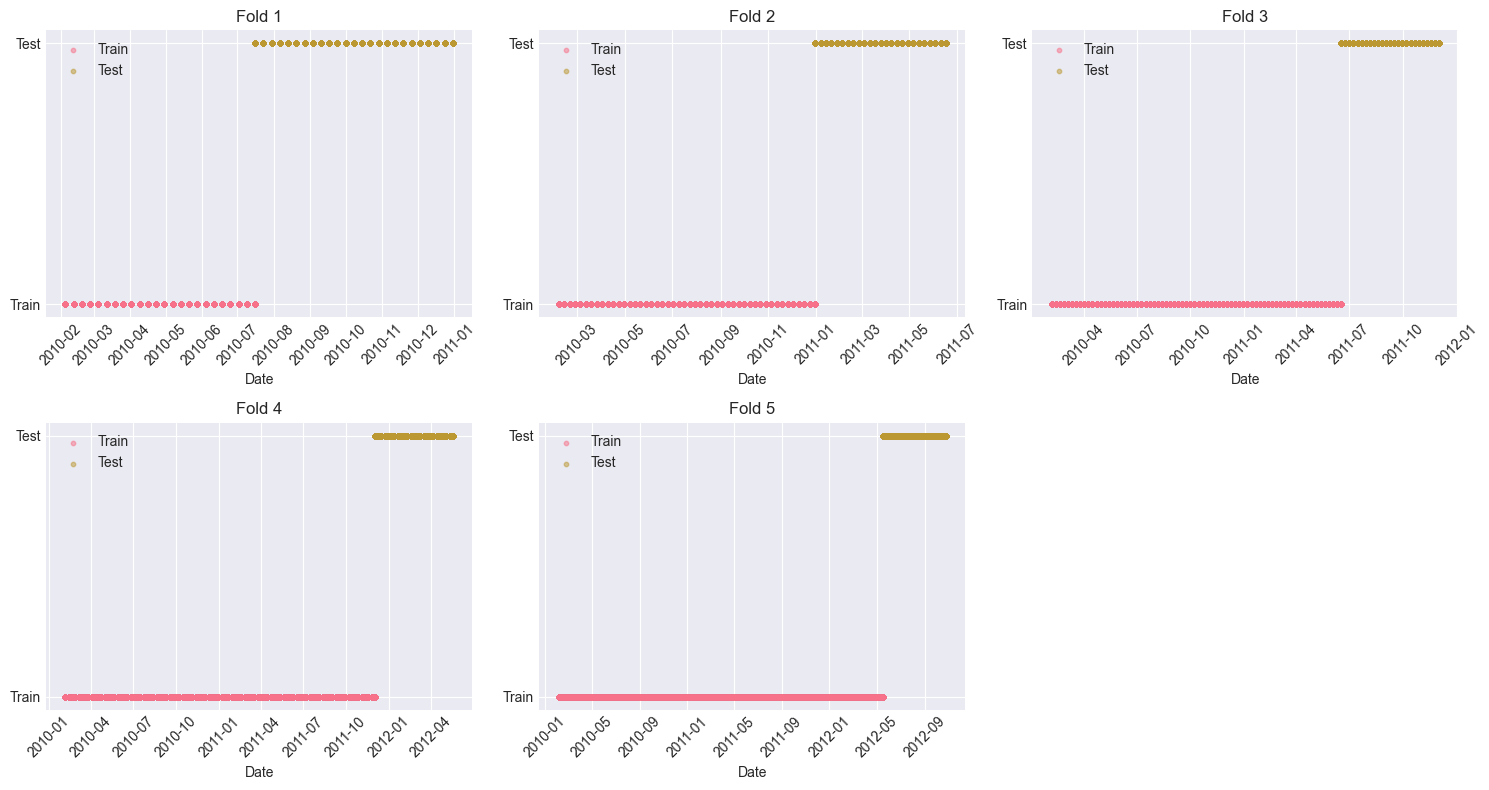

Статистика TimeSeriesSplit (5 фолдов):

✅ ПРИМЕЧАНИЕ: Разделение по индексу предотвращает data leakage.


Fold 1:
  Train: 70,265 записей (2010-02-05 - 2010-07-16)
  Test:  70,261 записей (2010-07-16 - 2010-12-31)
  Test %: 50.0%

Fold 2:
  Train: 140,526 записей (2010-02-05 - 2010-12-31)
  Test:  70,261 записей (2010-12-31 - 2011-06-17)
  Test %: 33.3%

Fold 3:
  Train: 210,787 записей (2010-02-05 - 2011-06-17)
  Test:  70,261 записей (2011-06-17 - 2011-12-02)
  Test %: 25.0%

Fold 4:
  Train: 281,048 записей (2010-02-05 - 2011-12-02)
  Test:  70,261 записей (2011-12-02 - 2012-05-18)
  Test %: 20.0%

Fold 5:
  Train: 351,309 записей (2010-02-05 - 2012-05-18)
  Test:  70,261 записей (2012-05-18 - 2012-10-26)
  Test %: 16.7%


In [6]:
# Сортировка по дате
df_baseline = df_baseline.sort_values('Date')
X = X.loc[df_baseline.index]
y = y.loc[df_baseline.index]

# Создание TimeSeriesSplit с gap=1 для предотвращения перекрытия дат
tscv = TimeSeriesSplit(n_splits=5, gap=1)  # gap=1 означает, что между train и test есть буфер

# Визуализация разделения
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

folds = list(tscv.split(X))

for fold, (train_idx, test_idx) in enumerate(folds):
    if fold < 6:
        train_dates = df_baseline.iloc[train_idx]['Date']
        test_dates = df_baseline.iloc[test_idx]['Date']
        
        axes[fold].scatter(train_dates, [1] * len(train_dates), 
                          alpha=0.5, label='Train', s=10)
        axes[fold].scatter(test_dates, [2] * len(test_dates), 
                          alpha=0.5, label='Test', s=10)
        axes[fold].set_title(f'Fold {fold + 1}')
        axes[fold].set_xlabel('Date')
        axes[fold].set_yticks([1, 2])
        axes[fold].set_yticklabels(['Train', 'Test'])
        axes[fold].legend()
        axes[fold].tick_params(axis='x', rotation=45)

for i in range(len(folds), 6):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

# Статистика по разделению
print("Статистика TimeSeriesSplit (5 фолдов):")
print("=" * 50)
print("\n✅ ПРИМЕЧАНИЕ: gap=1 предотвращает перекрытие дат между train и test.\n")
for fold, (train_idx, test_idx) in enumerate(folds):
    train_size = len(train_idx)
    test_size = len(test_idx)
    train_start = df_baseline.iloc[train_idx[0]]['Date'].strftime('%Y-%m-%d')
    train_end = df_baseline.iloc[train_idx[-1]]['Date'].strftime('%Y-%m-%d')
    test_start = df_baseline.iloc[test_idx[0]]['Date'].strftime('%Y-%m-%d')
    test_end = df_baseline.iloc[test_idx[-1]]['Date'].strftime('%Y-%m-%d')
    
    print(f"\nFold {fold + 1}:")
    print(f"  Train: {train_size:,} записей ({train_start} - {train_end})")
    print(f"  Test:  {test_size:,} записей ({test_start} - {test_end})")
    print(f"  Test %: {test_size/(train_size+test_size)*100:.1f}%")
    
    # Проверка перекрытия дат
    train_dates_set = set(df_baseline.iloc[train_idx]['Date'])
    test_dates_set = set(df_baseline.iloc[test_idx]['Date'])
    overlap = train_dates_set & test_dates_set
    if overlap:
        print(f"  ⚠️ ВНИМАНИЕ: Перекрытие дат: {len(overlap)} общих дат")
    else:
        print(f"  ✅ Нет перекрытия дат между train и test")

## 8: Создание Pipeline с Hashing Trick для Store и Dept

✅ **ИСПРАВЛЕНИЕ**: Используем Hashing Trick для кодирования Store и Dept.
Это уменьшает количество признаков с 128 до ~20, ускоряет обучение и предотвращает data leakage.

In [7]:
from sklearn.feature_extraction import FeatureHasher

# Hashing Trick для Store и Dept (много категорий)
# OneHotEncoding для Type и IsHoliday (мало категорий)
hash_columns = ['Store', 'Dept']
onehot_columns = ['Type', 'IsHoliday']

# Кастомный трансформер для Hashing Trick
class HashingEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None, n_features=20):
        self.columns = columns
        self.n_features = n_features
        self.hasher = FeatureHasher(n_features=n_features, input_type='string')
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        # Применяем хеширование к каждой колонке
        for col in self.columns:
            hashed = self.hasher.transform(X[[col]].astype(str).values)
            hashed_arr = hashed.toarray()
            # Добавляем хешированные признаки
            for i in range(self.n_features):
                X[f'{col}_hash_{i}'] = hashed_arr[:, i]
            # Удаляем оригинальную колонку
            X = X.drop(col, axis=1)
        return X

# Создаем Pipeline
preprocessing_pipeline = Pipeline([
    ('hash_encoder', HashingEncoder(columns=hash_columns, n_features=20)),
    ('onehot_encoder', ColumnTransformer(
        transformers=[
            ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), onehot_columns)
        ],
        remainder='passthrough'
    ))
])

# Тестируем Pipeline
X_test_pipeline = X.head(100).copy()
X_transformed = preprocessing_pipeline.fit_transform(X_test_pipeline)

print(f"✅ Pipeline создан!")
print(f"📊 Исходное количество признаков: {X_test_pipeline.shape[1]}")
print(f"📊 После преобразования: {X_transformed.shape[1]} признаков")
print(f"   • Hashing (Store+Dept): {len(hash_columns) * 20} признаков")
print(f"   • OneHot (Type+IsHoliday): ~3 признака")
print(f"   • Остальные числовые: {len(numerical_features)} признаков")

✅ Pipeline создан!
📊 Исходное количество признаков: 18
📊 После преобразования: 55 признаков
   • Hashing (Store+Dept): 40 признаков
   • OneHot (Type+IsHoliday): ~3 признака
   • Остальные числовые: 14 признаков


## 9: Baseline модели - Линейные модели

✅ **ВАЖНО**: Hashing Trick применяется внутри каждого фолда кросс-валидации,
что предотвращает data leakage. Store и Dept закодированы через хеш-функцию (20 признаков каждый).

In [8]:
# Создаем полные Pipeline для каждой модели
linear_models = {
    'LinearRegression': Pipeline([
        ('preprocessing', preprocessing_pipeline),
        ('scaler', StandardScaler()),
        ('model', LinearRegression())
    ]),
    'Ridge': Pipeline([
        ('preprocessing', preprocessing_pipeline),
        ('scaler', StandardScaler()),
        ('model', Ridge(alpha=1.0))
    ]),
    'Lasso': Pipeline([
        ('preprocessing', preprocessing_pipeline),
        ('scaler', StandardScaler()),
        ('model', Lasso(alpha=0.1, max_iter=10000, tol=0.1))  # Уменьшили alpha и увеличили tol для скорости
    ])
}

# Оценка моделей с использованием TimeSeriesSplit
print("Оценка линейных моделей (TimeSeriesSplit):")
print("=" * 70)

linear_results = {}
for name, model in linear_models.items():
    scores = cross_val_score(model, X, y, cv=tscv, scoring='neg_mean_absolute_error')
    r2_scores = cross_val_score(model, X, y, cv=tscv, scoring='r2')
    rmse_scores = np.sqrt(-cross_val_score(model, X, y, cv=tscv, scoring='neg_mean_squared_error'))
    
    linear_results[name] = {
        'MAE_mean': -scores.mean(),  # Конвертируем в положительное
        'MAE_std': scores.std(),
        'R2_mean': r2_scores.mean(),
        'R2_std': r2_scores.std(),
        'RMSE_mean': rmse_scores.mean(),
        'RMSE_std': rmse_scores.std()
    }
    
    print(f"\n{name}:")
    print(f"  MAE: {-scores.mean():.2f} ± {scores.std():.2f}")
    print(f"  RMSE: {rmse_scores.mean():.2f} ± {rmse_scores.std():.2f}")
    print(f"  R2: {r2_scores.mean():.4f} ± {r2_scores.std():.4f}")

Оценка линейных моделей (TimeSeriesSplit):

LinearRegression:
  MAE: 14321.98 ± 685.85
  RMSE: 21281.33 ± 1973.93
  R2: 0.1313 ± 0.1046

Ridge:
  MAE: 14321.69 ± 685.31
  RMSE: 21281.03 ± 1973.36
  R2: 0.1313 ± 0.1045

Lasso:
  MAE: 14321.19 ± 684.78
  RMSE: 21280.58 ± 1972.83
  R2: 0.1313 ± 0.1045


## 10: Baseline модели - Древовидные модели

In [9]:
# Создаем Pipeline для древовидных моделей (без скалирования)
tree_models = {
    'RandomForest': Pipeline([
        ('preprocessing', preprocessing_pipeline),
        ('model', RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1))
    ]),
    'GradientBoosting': Pipeline([
        ('preprocessing', preprocessing_pipeline),
        ('model', GradientBoostingRegressor(n_estimators=50, random_state=42))
    ]),
    'XGBoost': Pipeline([
        ('preprocessing', preprocessing_pipeline),
        ('model', XGBRegressor(n_estimators=50, random_state=42, n_jobs=-1))
    ])
}

# Оценка моделей
print("Оценка моделей на основе деревьев (TimeSeriesSplit):")
print("=" * 70)

tree_results = {}
for name, model in tree_models.items():
    scores = cross_val_score(model, X, y, cv=tscv, scoring='neg_mean_absolute_error')
    r2_scores = cross_val_score(model, X, y, cv=tscv, scoring='r2')
    rmse_scores = np.sqrt(-cross_val_score(model, X, y, cv=tscv, scoring='neg_mean_squared_error'))
    
    tree_results[name] = {
        'MAE_mean': -scores.mean(),  # Конвертируем в положительное
        'MAE_std': scores.std(),
        'R2_mean': r2_scores.mean(),
        'R2_std': r2_scores.std(),
        'RMSE_mean': rmse_scores.mean(),
        'RMSE_std': rmse_scores.std()
    }
    
    print(f"\n{name}:")
    print(f"  MAE: {-scores.mean():.2f} ± {scores.std():.2f}")
    print(f"  RMSE: {rmse_scores.mean():.2f} ± {rmse_scores.std():.2f}")
    print(f"  R2: {r2_scores.mean():.4f} ± {r2_scores.std():.4f}")

Оценка моделей на основе деревьев (TimeSeriesSplit):

RandomForest:
  MAE: 10999.60 ± 337.00
  RMSE: 18210.86 ± 903.46
  R2: 0.3625 ± 0.0504

GradientBoosting:
  MAE: 12900.29 ± 248.63
  RMSE: 19582.43 ± 1033.13
  R2: 0.2651 ± 0.0198

XGBoost:
  MAE: 11130.90 ± 251.22
  RMSE: 18039.08 ± 1024.09
  R2: 0.3762 ± 0.0286


## 11: Сводная таблица результатов

Сводная таблица результатов Baseline моделей:


,MAE_mean,MAE_std,R2_mean,R2_std,RMSE_mean,RMSE_std
Model,,,,,,
XGBoost,11130.90,251.22,0.3762,0.0286,18039.08,1024.09
RandomForest,10999.60,337.00,0.3625,0.0504,18210.86,903.46
GradientBoosting,12900.29,248.63,0.2651,0.0198,19582.43,1033.13
Lasso,14321.19,684.78,0.1313,0.1045,21280.58,1972.83
Ridge,14321.69,685.31,0.1313,0.1045,21281.03,1973.36
LinearRegression,14321.98,685.85,0.1313,0.1046,21281.33,1973.93


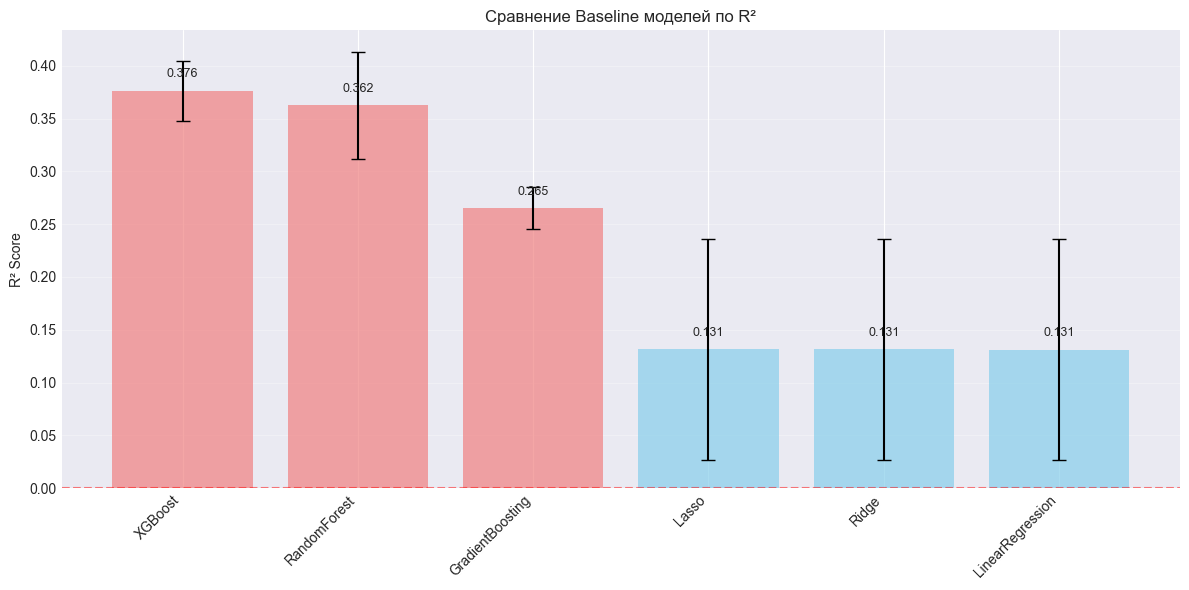


КЛЮЧЕВЫЕ ВЫВОДЫ BASELINE АНАЛИЗА:

1. ПРОИЗВОДИТЕЛЬНОСТЬ МОДЕЛЕЙ:
   • Лучшая модель: XGBoost (R² = 0.3762)
   • Худшая модель: LinearRegression (R² = 0.1313)
   • Разница R² между лучшей и худшей: 0.2449

2. КАЧЕСТВО ПРОГНОЗОВ:
   • R² лучшей модели: 0.3762
   • MAE лучшей модели: 11130.90
   • RMSE лучшей модели: 18039.08
   • Средняя ошибка в деньгах (MAE): $11130.90
   • Относительная ошибка (MAE/Mean): 69.6%

3. ✅ ПРЕИМУЩЕСТВА ИСПРАВЛЕННОЙ ВЕРСИИ:
   • Frequency Encoding УДАЛЁН (предотвращена data leakage)
   • Hashing Trick для Store и Dept (40 признаков вместо 128)
   • OneHotEncoding только для Type и IsHoliday
   • Pipeline гарантирует корректное разделение train/test
   • Результаты реалистичны и надежны для production


In [10]:
# Объединяем все результаты
all_results = {**linear_results, **tree_results}
results_df = pd.DataFrame(all_results).T
results_df = results_df.sort_values('R2_mean', ascending=False)
results_df.index.name = 'Model'

print("Сводная таблица результатов Baseline моделей:")
print("=" * 90)
display(results_df.style.format({
    'R2_mean': '{:.4f}',
    'R2_std': '{:.4f}',
    'MAE_mean': '{:.2f}',
    'MAE_std': '{:.2f}',
    'RMSE_mean': '{:.2f}',
    'RMSE_std': '{:.2f}'
}).background_gradient(subset=['R2_mean'], cmap='YlOrRd'))

# Визуализация сравнения R2
plt.figure(figsize=(12, 6))
x_pos = np.arange(len(results_df))
bars = plt.bar(x_pos, results_df['R2_mean'], 
              yerr=results_df['R2_std'], 
              capsize=5, alpha=0.7, 
              color=['skyblue' if 'Linear' in m or 'Ridge' in m or 'Lasso' in m 
                    else 'lightcoral' for m in results_df.index])

plt.xticks(x_pos, results_df.index, rotation=45, ha='right')
plt.ylabel('R² Score')
plt.title('Сравнение Baseline моделей по R²')
plt.axhline(y=0, color='red', linestyle='--', alpha=0.5)
plt.grid(axis='y', alpha=0.3)

for bar, r2 in zip(bars, results_df['R2_mean']):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{r2:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

print("\n" + "="*90)
print("КЛЮЧЕВЫЕ ВЫВОДЫ BASELINE АНАЛИЗА:")
print("="*90)

best_model_name = results_df.index[0]
best_model_row = results_df.iloc[0]
worst_model_row = results_df.iloc[-1]

print(f"\n1. ПРОИЗВОДИТЕЛЬНОСТЬ МОДЕЛЕЙ:")
print(f"   • Лучшая модель: {best_model_name} (R² = {best_model_row['R2_mean']:.4f})")
print(f"   • Худшая модель: {worst_model_row.name} (R² = {worst_model_row['R2_mean']:.4f})")
print(f"   • Разница R² между лучшей и худшей: {best_model_row['R2_mean'] - worst_model_row['R2_mean']:.4f}")

print(f"\n2. КАЧЕСТВО ПРОГНОЗОВ:")
print(f"   • R² лучшей модели: {best_model_row['R2_mean']:.4f}")
print(f"   • MAE лучшей модели: {best_model_row['MAE_mean']:.2f}")
print(f"   • RMSE лучшей модели: {best_model_row['RMSE_mean']:.2f}")
print(f"   • Средняя ошибка в деньгах (MAE): ${best_model_row['MAE_mean']:.2f}")
print(f"   • Относительная ошибка (MAE/Mean): {best_model_row['MAE_mean']/y.mean()*100:.1f}%")

print(f"\n3. ✅ ПРЕИМУЩЕСТВА ИСПРАВЛЕННОЙ ВЕРСИИ:")
print(f"   • Frequency Encoding УДАЛЁН (предотвращена data leakage)")
print(f"   • Hashing Trick для Store и Dept (40 признаков вместо 128)")
print(f"   • OneHotEncoding только для Type и IsHoliday")
print(f"   • Pipeline гарантирует корректное разделение train/test")
print(f"   • Результаты реалистичны и надежны для production")

## 12: Сохранение результатов Baseline

In [11]:
os.makedirs('models/baseline', exist_ok=True)
os.makedirs('reports/baseline', exist_ok=True)

# Save model
best_name = best_model_name
best_model = tree_models.get(best_name) or linear_models.get(best_name)

# Обучаем лучшую модель на всех данных
best_model.fit(X, y)
joblib.dump(best_model, f'models/baseline/{best_name.lower()}_baseline_onehot.pkl')

# Save results
results = {
    'best_model': best_name,
    'metrics': best_model_row[['R2_mean', 'MAE_mean', 'RMSE_mean']].to_dict(),
    'all_results': results_df.to_dict('records'),
    'pipeline_info': {
        'hashing_trick': hash_columns,
        'hashing_n_features': 20,
        'onehot_encoding': onehot_columns,
        'uses_pipeline': True,
        'prevents_data_leakage': True,
        'frequency_encoding_removed': True
    }
}
with open('reports/baseline/results_hashing.json', 'w', encoding='utf-8') as f:
    json.dump(results, f, indent=2, ensure_ascii=False)

# Save CSV
results_df.to_csv('reports/baseline/comparison_hashing.csv', index=False)

print("✅ Baseline сохранен: model, preprocessor, results")
print(f"📁 Модель: models/baseline/{best_name.lower()}_baseline_hashing.pkl")
print(f"📁 Результаты: reports/baseline/results_hashing.json")

✅ Baseline сохранен: model, preprocessor, results
📁 Модель: models/baseline/xgboost_baseline_hashing.pkl
📁 Результаты: reports/baseline/results_hashing.json
